In [1]:
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"

2.3.1+cu121
12.1


In [2]:
# version should match with torch and cuda
%%bash
pip install torch-scatter -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
pip install torch-sparse -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
pip install torch-cluster -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 107.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 55.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 21.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 14.4 MB/s eta 0:00:00


In [3]:
!pip install torch_geometric==2.2.0
!pip install torch_geometric_temporal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773275 sha256=bb029049e4805018a0ad24818a43eecac27ebd1f0eb09ff2ea05f755a37f24ed
  Stored in directory: /root/.cache/pip/wheels/c8/e4/83/5e964867e23f8a61cb8c5d5b9477617b710e96e6ebf1844562
Successfully built torch_geometric
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

import torch
import torch.nn.functional as F

from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.nn.attention import ASTGCN   # For information about the architecture check the source code

# GPU support
#DEVICE = torch.device('cuda') # cuda 有GPU記得加上
# 設置設備
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
shuffle=True
batch_size = 8

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# 從文件加載數據集的組件
data = torch.load('/content/drive/MyDrive/Dissertation/DissertationData/static_graph_temporal_signal.pt')

edge_index = data['edge_index']
edge_attr = data['edge_attr']
features_list = data['features']
targets_list = data['targets']

# 建 StaticGraphTemporalSignal 數據集
dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=edge_attr,
    features=features_list,
    targets=targets_list
)

# 打印數據集類型
print("Dataset type: ", type(dataset))

# 計算樣本數量（序列數量）
num_samples = sum(1 for _ in dataset)
print("Number of samples / sequences: ", num_samples)

# 顯示第一個樣本的內容
first_sample = next(iter(dataset))
print("First sample:", first_sample)

Dataset type:  <class 'torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal'>
Number of samples / sequences:  1940
First sample: Data(x=[5650, 1, 1], edge_index=[2, 47624], edge_attr=[47624], y=[5650, 1])


x=[5650, 1, 1]:

x 是特徵張量，形狀為 [num_nodes, num_features, timesteps]。這裡 num_nodes 是 5650，num_features 是 1，timesteps 是 1。這表示每個節點有一個特徵，且時間步長為 1（這與你的設置不完全一致，可能需要檢查設定）。
edge_index=[2, 47624]:

edge_index 是邊的索引，形狀為 [2, num_edges]，這裡 num_edges 是 47624，表示圖中的邊。
edge_attr=[47624]:

edge_attr 是邊的權重或相似度，形狀為 [num_edges]，這裡 num_edges 是 47624，與 edge_index 的邊數量一致。
y=[5650, 1]:

y 是目標張量，形狀為 [num_nodes, timesteps]，這裡 num_nodes 是 5650，timesteps 是 1。這表示每個節點在這個時間步長上的標籤值。

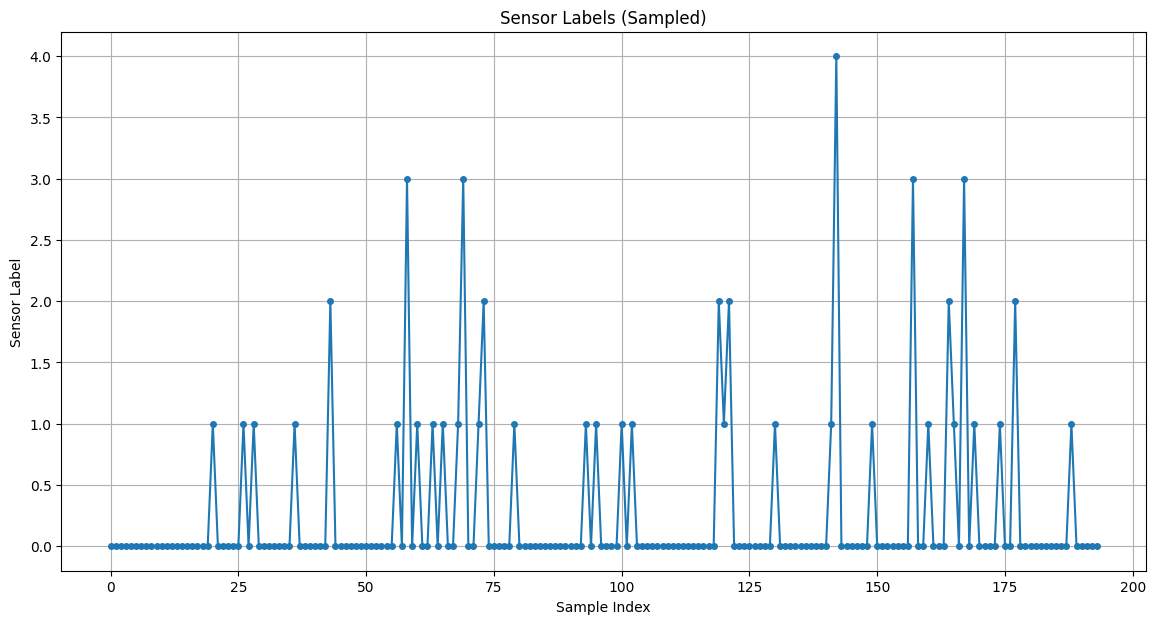

In [7]:
# 每隔 10 個數據點取樣
sensor_number = 1  # 觀察的傳感器
days = 1941  # 觀察365天的數據

# 從 dataset 中提取指定傳感器的真實標籤數據
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:days]]
interval = 10
sensor_labels_sampled = sensor_labels[::interval]

# 繪製取樣後的數據
plt.figure(figsize=(14, 7))
plt.plot(sensor_labels_sampled, marker='o', linestyle='-', markersize=4)
plt.title("Sensor Labels (Sampled)")
plt.xlabel("Sample Index")
plt.ylabel("Sensor Label")
plt.grid(True)
plt.show()

In [8]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

train_count = sum(1 for _ in train_dataset)
test_count = sum(1 for _ in test_dataset)

print("Number of train buckets: ", train_count)
print("Number of test buckets: ", test_count)

Number of train buckets:  1552
Number of test buckets:  388


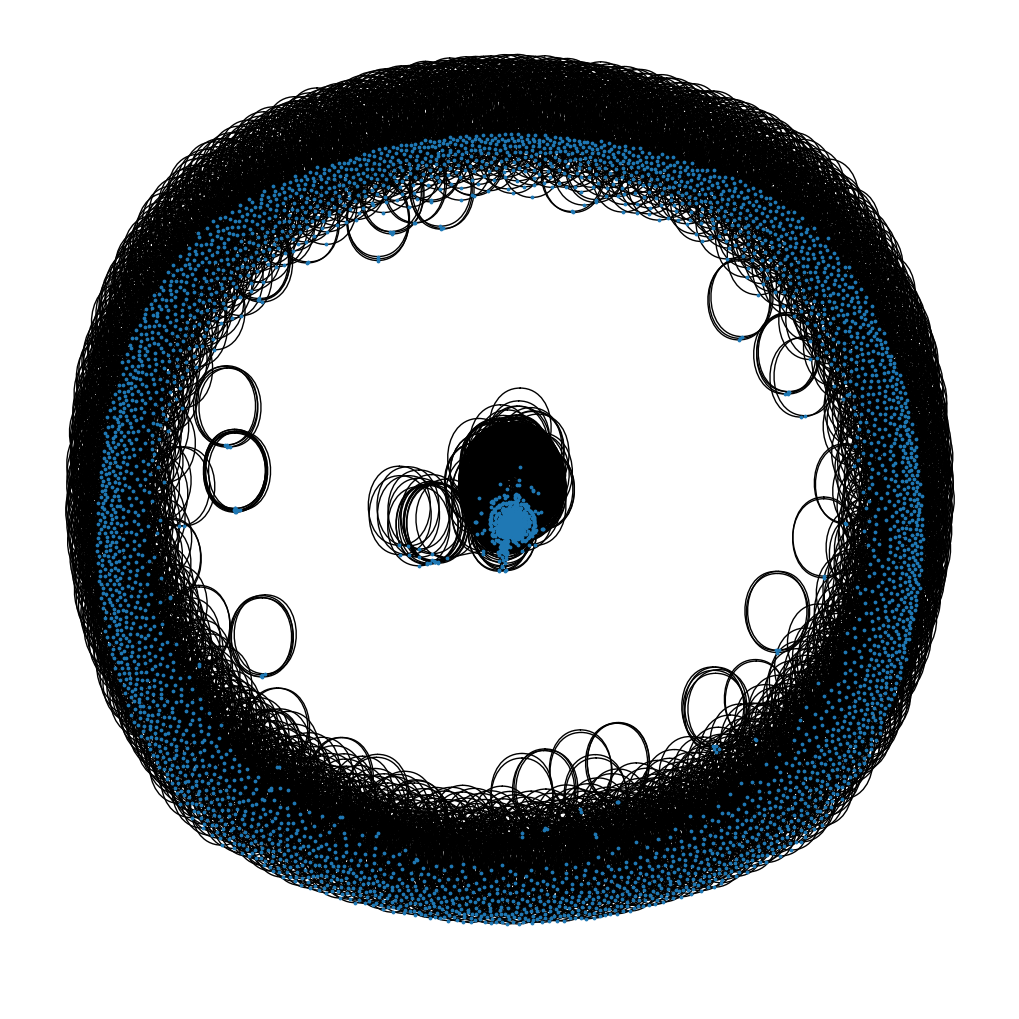

In [73]:
adj_matrix = np.load('/content/drive/MyDrive/Dissertation/DissertationData/adjacency_matrix.npy')
non_zero_elements = np.count_nonzero(adj_matrix)

if non_zero_elements > 0:
    # 繪製圖形
    rows, cols = np.where(adj_matrix > 0)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)

    plt.figure(figsize=(10, 10))  # 調整繪圖大小
    nx.draw(gr, node_size=3)
    plt.show()
else:
    print("The adjacency matrix contains no edges, and therefore no graph can be drawn.")

# ***Creating DataLoaders***

In [9]:
train_input = np.array(train_dataset.features) # e.g (27399, 207, 2, 12) / (1552, 5650, 1, 1)
train_target = np.array(train_dataset.targets) # e.g (27399, 207, 12) / (1552, 5650, 1)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

print(train_input.shape)
print(train_target.shape)
print(train_x_tensor.shape)
print(train_target_tensor.shape)
print(train_dataset_new)
print(train_loader)

(1552, 5650, 1, 1)
(1552, 5650, 1)
torch.Size([1552, 5650, 1, 1])
torch.Size([1552, 5650, 1])


In [10]:
test_input = np.array(test_dataset.features) # (, 207, 2, 12)
test_target = np.array(test_dataset.targets) # (, 207, 12)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

print(test_input.shape)
print(test_target.shape)
print(test_x_tensor.shape)
print(test_target_tensor.shape)
print(test_dataset_new)
print(test_loader)

(388, 5650, 1, 1)
(388, 5650, 1)
torch.Size([388, 5650, 1, 1])
torch.Size([388, 5650, 1])


# ***Model***

In [11]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=32, periods=periods,batch_size=batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = F.relu(h)
        h = self.linear(h)
        return h

# ***Graph loading***

In [14]:
hytuningForLearningRate = [0.001, 0.0001, 0.00001]

 Current Epoch 1
LOSS: [2.3557703495025635, 2.1656956672668457, 2.1090328693389893, 2.367427349090576, 2.178239107131958, 2.418606758117676, 2.0615952014923096, 2.019440174102783, 2.105569362640381, 2.147204637527466, 2.2718136310577393, 2.058588743209839, 2.5770413875579834, 2.1416540145874023, 2.0123744010925293, 2.446650266647339, 2.576110363006592, 2.0959293842315674, 2.0375657081604004, 2.1518311500549316, 2.0066399574279785, 2.104918956756592, 2.1208932399749756, 2.033209800720215, 2.1061246395111084, 2.0627670288085938, 2.02480149269104, 2.061574697494507, 2.0582151412963867, 2.2084498405456543, 2.018179416656494, 1.9848403930664062, 2.173011302947998, 2.512187957763672, 2.061561346054077, 2.0373075008392334, 1.8777908086776733, 1.9359934329986572, 2.0931777954101562, 1.9764680862426758, 1.9411174058914185, 2.1500277519226074, 2.049480438232422, 2.0279030799865723, 2.025618076324463, 2.0426909923553467, 2.0768542289733887, 1.969049334526062, 2.0744705200195312, 2.020484447479248

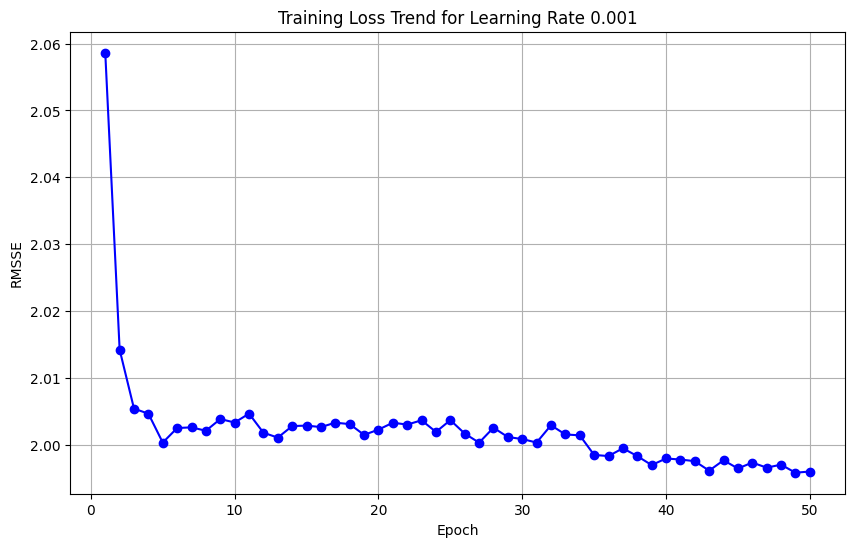

 Current Epoch 1
LOSS: [2.317279577255249, 2.1110687255859375, 2.073122501373291, 2.264507293701172, 2.0420615673065186, 2.1672348976135254, 2.211376667022705, 2.2597429752349854, 2.2757740020751953, 2.30855131149292, 2.3741607666015625, 2.1335835456848145, 2.3002727031707764, 2.059257984161377, 2.1843864917755127, 2.3519766330718994, 2.2298011779785156, 2.3002049922943115, 2.065504550933838, 2.152935743331909, 2.097461700439453, 2.3050215244293213, 2.0979411602020264, 2.1942222118377686, 2.24619197845459, 2.1493277549743652, 2.4922776222229004, 2.344083547592163, 2.3639495372772217, 2.290814161300659, 2.2303454875946045, 2.089094877243042, 2.2702698707580566, 2.10834002494812, 2.252173662185669, 2.019172191619873, 2.223775863647461, 2.282658815383911, 2.1200215816497803, 2.220700263977051, 2.297877550125122, 2.4158289432525635, 2.5821850299835205, 2.2430570125579834, 2.2456254959106445, 2.0976269245147705, 2.23909330368042, 2.291287422180176, 2.006540298461914, 2.1487631797790527] / L

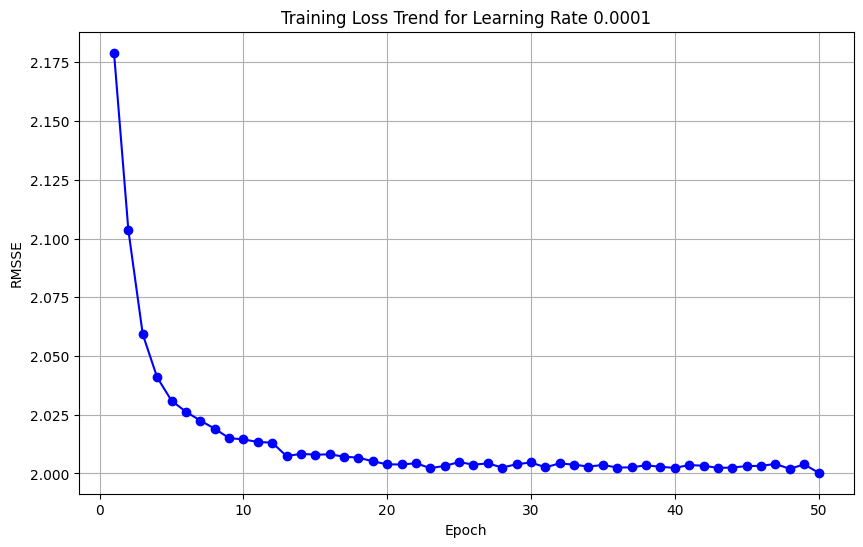

 Current Epoch 1
LOSS: [2.275620222091675, 2.2906885147094727, 2.2832746505737305, 2.066380500793457, 2.3217999935150146, 2.2642974853515625, 2.288262128829956, 2.236039638519287, 2.317336320877075, 2.3600876331329346, 2.197216272354126, 2.2811360359191895, 2.3229074478149414, 2.258535861968994, 2.216094970703125, 2.1179587841033936, 2.298341751098633, 2.0573253631591797, 2.27158784866333, 2.1031241416931152, 2.0577452182769775, 2.535644054412842, 2.304915189743042, 2.2078771591186523, 2.2598886489868164, 2.2851452827453613, 2.352674961090088, 2.30932354927063, 2.2135350704193115, 2.2225115299224854, 2.183370590209961, 2.364076614379883, 2.3667657375335693, 2.4509994983673096, 2.3364884853363037, 2.207334280014038, 2.2039308547973633, 2.255748987197876, 2.391087293624878, 2.338447332382202, 2.1851859092712402, 2.2136716842651367, 2.1959290504455566, 2.2308735847473145, 2.1121790409088135, 2.425652265548706, 2.4465999603271484, 2.4038336277008057, 2.254971742630005, 2.304879903793335] /

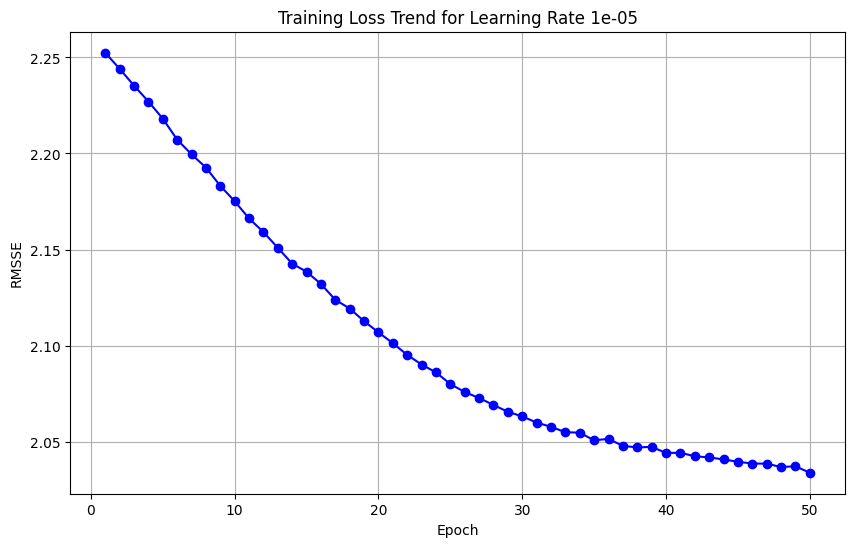

In [16]:
for learning_rate in hytuningForLearningRate:
    model = TemporalGNN(node_features=1, periods=1, batch_size=batch_size).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for snapshot in train_dataset:
        static_edge_index = snapshot.edge_index.to(DEVICE)
        break

    # 訓練設置
    num_epochs = 50  # 訓練的總 epoch 數
    epoch_losses = []  # 用來存儲每個 epoch 的平均損失

    # 模型訓練過程
    model.train()

    for epoch in range(num_epochs):
        print(f" Current Epoch {epoch + 1}")
        step = 0
        loss_list = []  # 每個 epoch 開始時初始化損失列表

        for encoder_inputs, labels in train_loader:
            y_hat = model(encoder_inputs, static_edge_index)  # 模型預測

            # 計算RMSSE的分母，即平均絕對誤差 (MAE) of lagged values
            scale = torch.mean(torch.abs(labels[:, 1:] - labels[:, :-1]))

            # 計算RMSSE損失
            rmsse_loss = torch.sqrt(torch.mean(((labels - y_hat) / scale) ** 2))

            rmsse_loss.backward()  # 反向傳播
            optimizer.step()  # 更新模型參數
            optimizer.zero_grad()  # 清零梯度
            step += 1
            loss_list.append(rmsse_loss.item())  # 記錄當前批次的損失

            # 每4個批次打印一次當前損失和平均損失
            if step % 50 == 0:
                print("LOSS: {} / LOSS AVG: {:.4f}".format(loss_list, sum(loss_list)/len(loss_list)))

        # 計算並存儲當前 epoch 的平均損失
        epoch_loss = sum(loss_list) / len(loss_list)
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1} RMSSE: {epoch_loss:.4f}")

    # 繪製損失隨 epochs 的收斂圖
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
    plt.title(f'Training Loss Trend for Learning Rate {learning_rate}')
    plt.xlabel('Epoch')
    plt.ylabel('RMSSE')
    plt.grid(True)
    plt.show()

 Current Epoch 1
Epoch 1 RMSSE: 2.0772
 Current Epoch 2
Epoch 2 RMSSE: 2.0134
 Current Epoch 3
Epoch 3 RMSSE: 2.0064
 Current Epoch 4
Epoch 4 RMSSE: 2.0064
 Current Epoch 5
Epoch 5 RMSSE: 2.0031
 Current Epoch 6
Epoch 6 RMSSE: 2.0022
 Current Epoch 7
Epoch 7 RMSSE: 2.0020
 Current Epoch 8
Epoch 8 RMSSE: 2.0007
 Current Epoch 9
Epoch 9 RMSSE: 2.0007
 Current Epoch 10
Epoch 10 RMSSE: 2.0025
 Current Epoch 11
Epoch 11 RMSSE: 2.0015
 Current Epoch 12
Epoch 12 RMSSE: 1.9992
 Current Epoch 13
Epoch 13 RMSSE: 2.0019
 Current Epoch 14
Epoch 14 RMSSE: 2.0021
 Current Epoch 15
Epoch 15 RMSSE: 2.0010
 Current Epoch 16
Epoch 16 RMSSE: 2.0005
 Current Epoch 17
Epoch 17 RMSSE: 2.0009
 Current Epoch 18
Epoch 18 RMSSE: 2.0004
 Current Epoch 19
Epoch 19 RMSSE: 1.9998
 Current Epoch 20
Epoch 20 RMSSE: 2.0013
 Current Epoch 21
Epoch 21 RMSSE: 1.9999
 Current Epoch 22
Epoch 22 RMSSE: 2.0008
 Current Epoch 23
Epoch 23 RMSSE: 2.0004
 Current Epoch 24
Epoch 24 RMSSE: 1.9990
 Current Epoch 25
Epoch 25 RMSSE: 

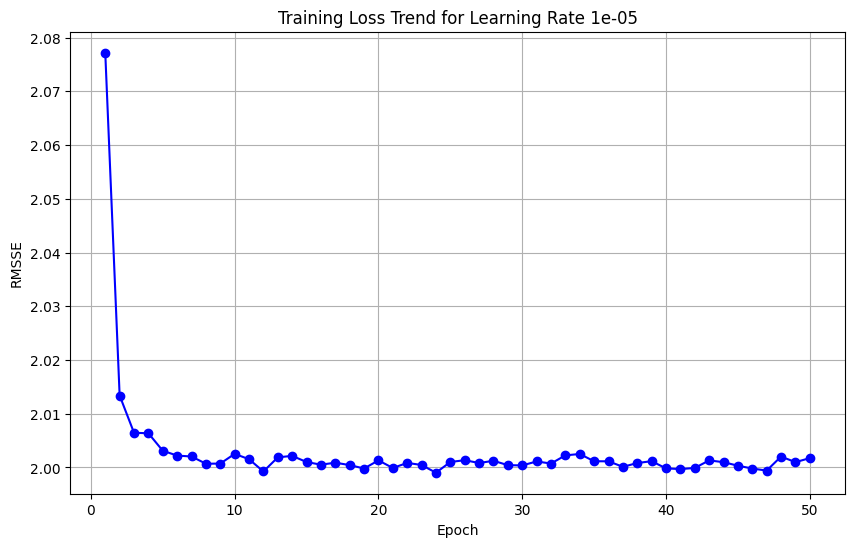

In [19]:
#lr = 0.001 is the best
model = TemporalGNN(node_features=1, periods=1, batch_size=batch_size).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    break

# 訓練設置
num_epochs = 50  # 訓練的總 epoch 數
epoch_losses = []  # 用來存儲每個 epoch 的平均損失

# 模型訓練過程
model.train()

for epoch in range(num_epochs):
    print(f" Current Epoch {epoch + 1}")
    step = 0
    loss_list = []  # 每個 epoch 開始時初始化損失列表

    for encoder_inputs, labels in train_loader:
        y_hat = model(encoder_inputs, static_edge_index)  # 模型預測

        # 計算RMSSE的分母，即平均絕對誤差 (MAE) of lagged values
        scale = torch.mean(torch.abs(labels[:, 1:] - labels[:, :-1]))

        # 計算RMSSE損失
        rmsse_loss = torch.sqrt(torch.mean(((labels - y_hat) / scale) ** 2))

        rmsse_loss.backward()  # 反向傳播
        optimizer.step()  # 更新模型參數
        optimizer.zero_grad()  # 清零梯度
        step += 1
        loss_list.append(rmsse_loss.item())  # 記錄當前批次的損失

    # 計算並存儲當前 epoch 的平均損失
    epoch_loss = sum(loss_list) / len(loss_list)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch + 1} RMSSE: {epoch_loss:.4f}")

# 繪製損失隨 epochs 的收斂圖
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
plt.title(f'Training Loss Trend for Learning Rate {learning_rate}')
plt.xlabel('Epoch')
plt.ylabel('RMSSE')
plt.grid(True)
plt.show()

# ***Evaluate***

In [47]:
# 初始化訓練數據標籤，用於 WRMSSE 計算
train_labels = []

# 遍歷訓練集來收集所有標籤
for encoder_inputs, labels in train_loader:
    train_labels.append(labels.cpu().numpy())  # 將張量轉換為 NumPy 數組並收集

# 將所有的標籤堆疊成一個大的 NumPy 數組
y_train_np = np.vstack(train_labels)

In [48]:
def calculate_wrmsse(y_true, y_pred, y_train, weights=None, epsilon=1e-10):
    """
    計算 WRMSSE 的函數。

    參數:
    - y_true: 真實值 (numpy array)
    - y_pred: 預測值 (numpy array)
    - y_train: 訓練集的真實值 (numpy array)
    - weights: 每個時間序列的權重 (numpy array)，默認為 None
    - epsilon: 防止除零的小正數

    返回:
    - wrmsse: 计算出的 WRMSSE 值
    """
    # 確保輸入是 numpy 陣列
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_train = np.asarray(y_train)

    # 計算均方誤差（MSE）
    mse = np.mean((y_true - y_pred) ** 2, axis=0)

    # 計算差分的均方差（用於 RMSSE 計算的分母）
    diff = np.diff(y_train, axis=0) ** 2
    denominator = np.mean(diff, axis=0, keepdims=True)

    # 確保 denominator 的形狀與 mse 一致
    denominator = np.squeeze(denominator)  # 去掉多餘的維度
    if denominator.ndim == 1:
        denominator = denominator.reshape(1, -1)

    # 避免分母為零：將分母為零的地方設置為一個小正數
    valid_denominator = denominator > epsilon
    denominator[~valid_denominator] = epsilon

    # 計算 RMSSE
    rmsse = np.sqrt(mse / denominator)

    # 只選擇有效分母的位置進行計算
    valid_rmsse = rmsse[valid_denominator]

    # 計算加權 RMSSE（如果權重存在）
    if weights is not None:
        weights = np.asarray(weights)[valid_denominator]  # 只選擇有效分母的權重
        wrmsse = np.sum(weights * valid_rmsse)
    else:
        wrmsse = np.mean(valid_rmsse)

    return wrmsse

In [50]:
def calculate_rmse(y_true, y_pred):
    """
    計算 RMSE 的函數。

    參數:
    - y_true: 真實值 (numpy array)
    - y_pred: 預測值 (numpy array)

    返回:
    - rmse: 計算出的 RMSE 值
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

In [65]:
def calculate_rmsse(y_true, y_pred, y_train, epsilon=1e-10):
    """
    計算 RMSSE 的函數。

    參數:
    - y_true: 真實值 (numpy array)
    - y_pred: 預測值 (numpy array)
    - y_train: 訓練集的真實值 (numpy array)
    - epsilon: 防止除零的小正數，默認為1e-10

    返回:
    - rmsse: 計算出的 RMSSE 值
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_train = np.asarray(y_train)

    # 計算均方誤差（MSE）
    mse = np.mean((y_true - y_pred) ** 2)

    # 計算差分的均方差（用於 RMSSE 計算的分母）
    diff = np.diff(y_train, axis=0) ** 2
    denominator = np.mean(diff)

    # 避免分母為零
    if denominator == 0:
        denominator = epsilon

    rmsse = np.sqrt(mse / denominator)
    return rmsse

In [57]:
def calculate_mape(y_true, y_pred):
    """
    計算 MAPE 的函數。

    參數:
    - y_true: 真實值 (numpy array)
    - y_pred: 預測值 (numpy array)

    返回:
    - mape: 計算出的 MAPE 值，以百分比表示
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # 忽略 y_true 為零的情況
    non_zero_indices = y_true != 0
    y_true = y_true[non_zero_indices]
    y_pred = y_pred[non_zero_indices]

    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [66]:
# 設置模型為評估模式
model.eval()

# 用於存儲測試集的預測和真實值
y_test_pred = []
y_test_true = []

# 不計算梯度（因為這是評估模式）
with torch.no_grad():
    for encoder_inputs, labels in test_loader:
        encoder_inputs = encoder_inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # 使用模型進行預測
        y_hat = model(encoder_inputs, static_edge_index)
        y_hat_np = y_hat.squeeze(-1).detach().cpu().numpy()  # 調整形狀
        labels_np = labels.squeeze(-1).detach().cpu().numpy()  # 調整形狀

        y_test_pred.append(y_hat_np)
        y_test_true.append(labels_np)

# 將所有批次的結果拼接為一個NumPy數組
y_test_pred = np.concatenate(y_test_pred, axis=0)
y_test_true = np.concatenate(y_test_true, axis=0)

# 計算 RMSE
rmse = calculate_rmse(y_test_true, y_test_pred)
print(f'Test RMSE: {rmse:.4f}')
# 計算 RMSSE
rmsse = calculate_rmsse(y_test_true, y_test_pred, y_train_np)
print(f'Test RMSSE: {rmsse:.4f}')
# 計算 MAPE
mape = calculate_mape(y_test_true, y_test_pred)
print(f'Test MAPE: {mape:.2f}%')
# 計算 WRMSSE
wrmsse = calculate_wrmsse(y_test_true, y_test_pred, y_train_np)
print(f'Test WRMSSE: {wrmsse:.4f}')


Test RMSE: 2.0274
Test RMSSE: 0.8317
Test MAPE: 67.80%
Test WRMSSE: 1.1580


根據你最新提供的結果，以下是模型訓練和測試的評估指標：

- **訓練集 RMSSE** (`Epoch 50 RMSSE`): `2.0017`
- **測試集 RMSE** (`Test RMSE`): `2.0274`
- **測試集 RMSSE** (`Test RMSSE`): `0.8317`
- **測試集 MAPE** (`Test MAPE`): `67.80%`
- **測試集 WRMSSE** (`Test WRMSSE`): `1.1580`


1. **訓練集 RMSSE (2.0017)**:
   - 訓練集的 RMSSE 是 `2.0017`，這表示在訓練期間模型預測的標準化誤差較大。這可能表明模型在訓練過程中存在一定的誤差，預測的準確性仍然有提升空間。

2. **測試集 RMSE (2.0274)**:
   - 測試集 RMSE 是 `2.0274`，這表明模型在測試數據上的預測誤差與訓練數據上的誤差相當。這是一個好的信號，表明模型沒有過度擬合訓練數據，並且在測試數據上的表現也很穩定。

3. **測試集 RMSSE (0.8317)**:
   - 測試集 RMSSE 是 `0.8317`，這表示模型在測試數據上的標準化誤差低於訓練數據上的誤差。RMSSE < 1 表示模型的預測比簡單的基線（例如使用訓練數據的平均值進行預測）更好。

4. **測試集 MAPE (67.80%)**:
   - 測試集 MAPE 是 `67.80%`，這表明預測值和真實值之間的平均百分比誤差仍然相對較大。這可能是由於數據集中存在變異性較大的數據點，或模型無法很好地擬合某些特定的樣本。

5. **測試集 WRMSSE (1.1580)**:
   - 測試集 WRMSSE 是 `1.1580`，這表示模型考慮了時間序列波動後的加權平均誤差，結果在合理範圍內。

### 進一步的分析和建議

1. **降低訓練集的 RMSSE**:
   - **增加訓練次數**：考慮進一步增加訓練次數（`num_epochs`），這可能有助於降低訓練集 RMSSE。
   - **調整模型架構**：增加隱藏層的神經元數量或層數，這可能有助於捕捉數據的更多特徵。
   - **正則化**：考慮增加 L1 或 L2 正則化，這可以幫助模型避免過度擬合。

2. **降低測試集的 MAPE**:
   - **數據預處理**：檢查數據中的異常值或極端值，並考慮對數據進行去極值或平滑處理。
   - **模型改進**：嘗試其他模型架構，如 LSTM、GRU 或混合模型（例如 CNN + RNN），這些模型可能對某些數據類型的預測更為精確。

3. **保持測試集 RMSE 和 RMSSE 的穩定性**:
   - 現在測試集 RMSE 和 RMSSE 都較為穩定，這表明模型在測試數據上的泛化能力良好。繼續保持這種狀態的模型改進策略。

4. **增加特徵**:
   - 在數據集的基礎上，考慮引入更多的外生特徵（如季節性指標、滯後特徵等），這可能有助於提高模型的預測能力。

總結來說，你的模型目前表現出較為穩定的預測能力，但仍然存在進一步改進的空間。通過模型調整和數據預處理，你可以進一步降低 RMSSE 和 MAPE，以提高模型的整體性能

# ***Visualisation***

In [63]:
sensor = 123
timestep = 0 #根據時間改動 #時間步減1
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (8,)


<Axes: >

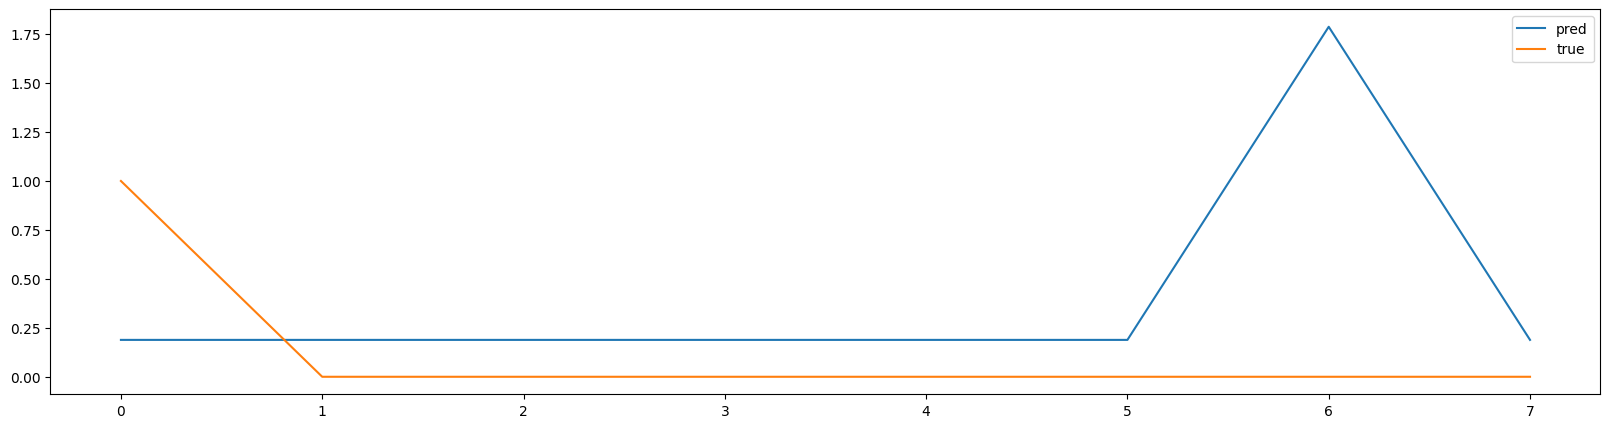

In [64]:
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")